# **Exploratory Data Analysis on Face Recognition!**

#  **Data** **Gathering**

In [0]:
!git clone https://github.com/NightFury010497/Udacity_Data_Scientist_NanoDegree

Cloning into 'Udacity_Data_Scientist_NanoDegree'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 183 (delta 69), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (183/183), 26.25 MiB | 12.59 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [0]:
# unzipping files and creating output folders
!unzip /content/model_paths.zip
!unzip /content/models.zip
!unzip /content/data.zip
!mv /content/data/ /content/dataset
!mkdir predictedImg
!mkdir output

# **ASSESSING** Data in Folder DATASET

In [0]:
!ls /content/dataset

'APJ Abdul Kalam'   data   dhoni   modi   sachin   srk	 viratKohili


In [0]:
!ls /content/dataset/dhoni

dhoni-10.jpg  dhoni-2.jpeg  dhoni-4.jpeg  dhoni-6.jpg	dhoni-8.jpg
dhoni-1.jpeg  dhoni-3.jpeg  dhoni-5.jpeg  dhoni-7.jpeg	dhoni-9.jpg


# Let's check out the Height and Width of images

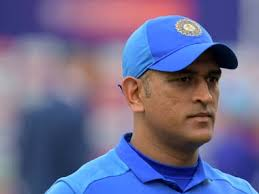

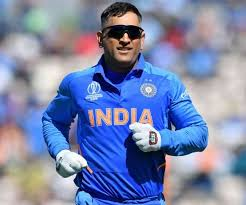

In [0]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/dataset/dhoni/dhoni-1.jpeg')
img2 = cv2.imread('/content/dataset/dhoni/dhoni-2.jpeg')
cv2_imshow(img)
cv2_imshow(img2)


modi-10.jpg  modi-2.jpeg  modi-4.jpeg  modi-6.jpg   modi-8.jpg
modi-1.jpeg  modi-3.jpeg  modi-5.jpeg  modi-7.jpeg  modi-9.jpg
(440, 660, 3)
(155, 326, 3)


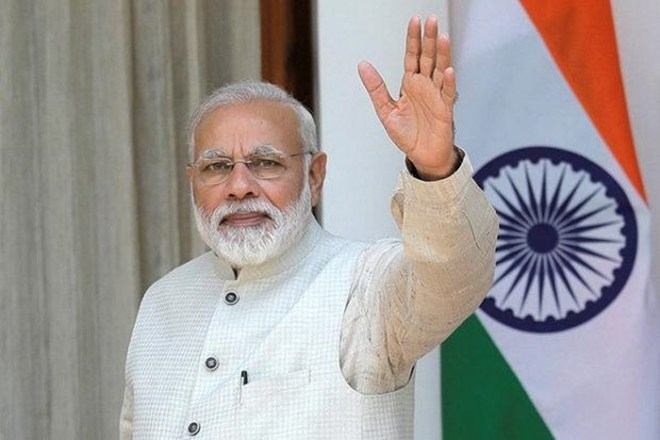

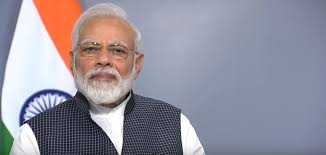

In [0]:
!ls /content/dataset/modi
img = cv2.imread('/content/dataset/modi/modi-9.jpg')
print(img.shape)
img2 = cv2.imread('/content/dataset/modi/modi-2.jpeg')
print(img2.shape)
cv2_imshow(img)
cv2_imshow(img2)



We can push images without thinking about their height and width!

--------------------------------------------------------------------------------------------------------------


In [0]:
!pip freeze > requirements.txt

# Importing Necesarry Libraries!

In [0]:
# Import the necessary packages
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os
import model as embedding
import model
from PIL import Image
import torchvision.transforms.functional as TF
import csv
import pandas as pd
import matplotlib.pyplot as plt
import torch

# **LOAD** PRETRAINED MODEL 

In [0]:
# load face detection model
protoPath = "./model_paths/deploy.prototxt.txt"
modelPath = "./model_paths/res10_300x300_ssd_iter_140000.caffemodel"

# Fetching **Detector** and **Embedder** INCEPTION RESNETV1

In [0]:
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained='vggface2').eval()

# Setting **Paths** to directories

In [0]:
currentDir = os.getcwd()

dataset = os.path.join(currentDir, "dataset")

datasetCrop = os.path.join(currentDir, "datasetCrop")

embeddingPickle = os.path.join(currentDir, "output/embeddings2.pickle")

# getting all images paths
imagePaths = list(paths.list_images(dataset))

# **CLEANING** IMAGES by RESIZING THEM TO (300,300) and Creating Encodings of FACES DETECTED! 
# **And taking care of Missing values!**

In [0]:
#loop over the image paths
ImgPaths = []
names = []
imageIDs = []
boxs = []
embeddings = []

# initlize the total number of faces processed
total = 0

for (i, imagePath) in enumerate(imagePaths):
    
    #extract the person name from the image path
    
    name = imagePath.split(os.path.sep)[-2]
    imageID = imagePath.split(os.path.sep)[-1].split('.')[-2]
    print(name)
    image = cv2.imread(imagePath)
    (h,w) = image.shape[:2]
    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))    # CLEANING by RESIZING IMAGES TO (300*300)
    
    detector.setInput(blob)
    detections = detector.forward()
    
    if len(detections) > 0:
        
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        
        # ensure that the detection with the largest probability also
        # means our minimum probability test (to  filter out weak detections done by model)
        
        if confidence > 0.5:
            
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            
            (startX, startY, endX, endY) = box.astype("int")
            
            face = image[startY:endY , startX:endX]
            (fH , fW) = face.shape[:2]
            
            
            # ensure the facce width and height are sufficently large
            if fW < 20 or fH < 20:
                continue
                
            try:
                faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
            except:
                print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)     # if the face is empty it  will prompt an Error!
                continue                                                                                
            
            faceTensor = torch.tensor(faceBlob)
            faceEmbed = embedder(faceTensor)
            flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
            
            ImgPaths.append(imagePath)
            imageIDs.append(imageID)
            names.append(name)
            boxs.append(box)
            embeddings.append(flattenEmbed)
            total += 1

# dump the facial embeddings + names to disk
print("Serializing {} total encodings ....".format(total))
# ingesting it in a PICKLE file!
data = {"paths":ImgPaths, "names":names, "imageIDs":imageIDs, "boxs":boxs, "embeddings":embeddings}
f = open(embeddingPickle , "wb")
f.write(pickle.dumps(data))
f.close()

# **ANALYZING**  THE PICKLE FILE

In [0]:
import pandas as pd
picklefile = pd.read_pickle(embeddingPickle)
df = pd.DataFrame(picklefile)
df.head()
#PATHS - Path to image
#name  - Name of the person
#imageIDs - BaseName of the images
#boxs      - Bounding Boxes of Faces
#embeddings  - Embeddings Generated of Size 512*1  (512-D VECTOR)

,paths,names,imageIDs,boxs,embeddings
0,/content/dataset/APJ Abdul Kalam/kalam-10.jpg,APJ Abdul Kalam,kalam-10,"[601.4799118041992, 259.4201850891113, 1027.78...","[0.042348713, -0.05237531, 0.00901053, 0.00418..."
1,/content/dataset/APJ Abdul Kalam/kalam-2.jpeg,APJ Abdul Kalam,kalam-2,"[103.40272441506386, 22.631577253341675, 160.6...","[0.05177761, -0.085736305, 0.006579192, -0.027..."
2,/content/dataset/APJ Abdul Kalam/kalam-9.jpg,APJ Abdul Kalam,kalam-9,"[156.23179137706757, 40.7753124833107, 237.488...","[0.05452933, -0.048953768, 0.010514522, -0.008..."
3,/content/dataset/APJ Abdul Kalam/kalam-4.jpeg,APJ Abdul Kalam,kalam-4,"[92.56910872459412, 28.98782005906105, 191.133...","[0.048352446, -0.06827172, 0.023411488, -0.022..."
4,/content/dataset/APJ Abdul Kalam/kalam-7.jpg,APJ Abdul Kalam,kalam-7,"[511.0686421394348, 200.2178471982479, 735.920...","[0.0511497, -0.043594446, -0.008298743, 0.0064..."


# **Can we visualize a 512-D Vector?**

In [0]:
df['embeddings'][0].shape

(512,)

**T-SNE - t-distributed stochastic neighbor embedding**

Extremely useful for visualizing high-dimensional data, t-SNE plots can sometimes be mysterious or misleading.Bur the best way to demonstrate a **High Dimension vector** in a **2-Dimension**.

## T-SNE **visualization**

In [0]:
#importing libraries to for visualization
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
X = np.array(picklefile["embeddings"])
Y = picklefile["names"]
print(X.shape)

(126, 512)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


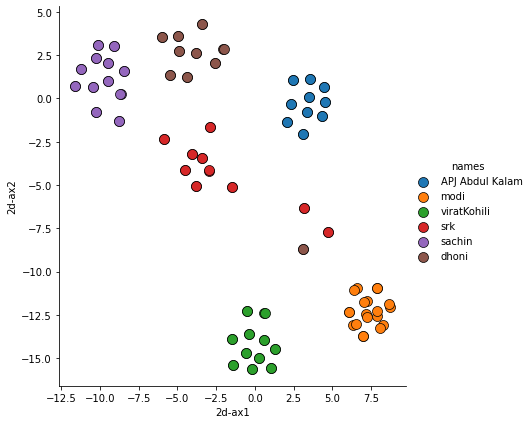

In [0]:
# Loading TSNE
model = TSNE(n_components=2)
# fitting the Model
tsne_data = model.fit_transform(X)

df["2d-ax1"] = tsne_data[:,0]
df["2d-ax2"] = tsne_data[:,1]

kws = dict(s=100, linewidth=.7, edgecolor="k")
sns.FacetGrid(df, hue="names", size=6).map(plt.scatter, '2d-ax1', '2d-ax2' , **kws).add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


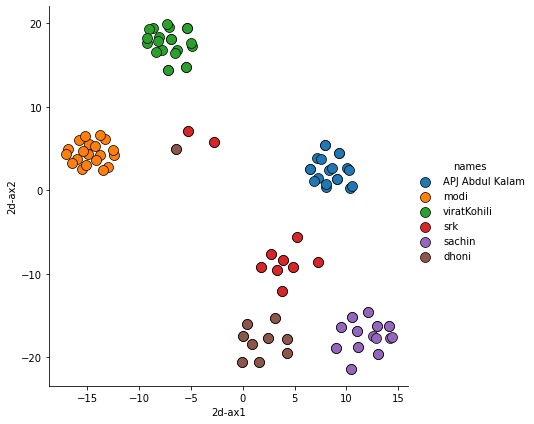

In [0]:
model = TSNE(n_components=2, perplexity=20)

tsne_data = model.fit_transform(X)

df["2d-ax1"] = tsne_data[:,0]
df["2d-ax2"] = tsne_data[:,1]

kws = dict(s=100, linewidth=.7, edgecolor="k")
sns.FacetGrid(df, hue="names", size=6).map(plt.scatter, '2d-ax1', '2d-ax2' , **kws).add_legend()

# **Is there any easier way to recognize faces by using any Machine Learning Algorithm to get better results?**

## ML Models

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# **Label Encoding the Categorical Variables**

In [0]:
Embeddings = np.array(picklefile["embeddings"])
Labels = np.array(picklefile["names"])

# label Encoding  Taking care of categorical Values
le = LabelEncoder()
labels = le.fit_transform(Labels)

X_train, X_test, y_train, y_test = train_test_split(Embeddings, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 512)
(26, 512)
(100,)
(26,)


# **Categorical Variables - Labels including the Classification of people whose images we have trained on let us check them**

In [0]:
set(y_train)

{0, 1, 2, 3, 4, 5}

In [0]:
set(y_test)

{0, 1, 2, 3, 4, 5}

# **Data  modeling**

In [0]:
knn = KNeighborsClassifier(n_neighbors=1 , metric='euclidean', weights="distance")
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn * 100}, SVM accuracy = {acc_svc * 100}')

KNN accuracy = 100.0, SVM accuracy = 100.0


## **Can we SET A THRESHOLD for better Verification?**


In [0]:
Embeddings = np.array(picklefile["embeddings"])
Labels = labels

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Best threshold =  1.04
##### Best F1-Score =  0.9302510960542049
##### Best Accurecy =  0.9776


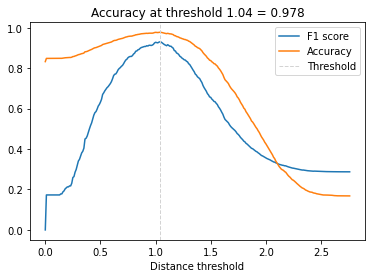

In [0]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # L2 distance
identical = [] #1 if same identity, 0 otherwise

num = len(Embeddings)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(Embeddings[i], Embeddings[j]))
        identical.append(1 if labels[i] == labels[j] else 0)
        
distances = np.array(distances)
identical = np.array(identical)

minDist = min(distances)
maxDist = max(distances)

thresholds = np.arange(minDist, maxDist, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
#Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal accurecy
opt_acc = accuracy_score(identical, distances < opt_tau)

print("##### Best threshold = ", opt_tau)
print("##### Best F1-Score = ", f1_scores[opt_idx])
print("##### Best Accurecy = ", opt_acc)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();


## **Can we find out the Distance distributions of both  positive and negative pairs ?**



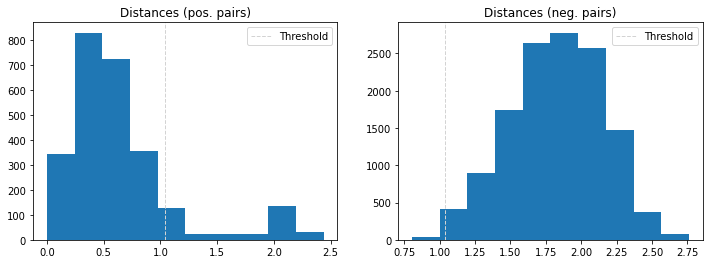

In [0]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## Train a model

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
import numpy as np

In [0]:
embeddingPickle = os.path.join(currentDir, "output/embeddings2.pickle")

recognizerPickle = "./output/recognizer2.pickle"

labelPickle = "./output/labelPickle2.pickle"

data = pickle.loads(open(embeddingPickle, "rb").read())

# encode the labels
le = LabelEncoder()
labels = le.fit_transform(data["names"])

#Embeddings
Embeddings = np.array(data["embeddings"])

# train the model used to accept the 512-d embeddings of the face and 
# then produce the actual face recognition

#recognizer = KNeighborsClassifier(n_neighbors= 2, metric='euclidean', weights="distance")   # KKNeighborsClassifier
recognizer = SVC(probability=True)                                                           # SVC
# FITTING THE MODEL!
recognizer.fit(Embeddings, labels)  

# write the actual face recognition model to disk
f = open(recognizerPickle, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(labelPickle,"wb")
f.write(pickle.dumps(le))
f.close()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# **How about we create a recognizer to further help in Recognizing faces?**

## **Recognizer**

In [0]:
import numpy as np
import imutils
import pickle
import cv2
import os
import model as embedding
from imutils import paths
from PIL import Image

In [0]:
imagePath = "/content/dataset/dhoni/dhoni-1.jpeg"

In [0]:
# load face detectection model

protoPath = "./model_paths/deploy.prototxt.txt"
modelPath = "./model_paths/res10_300x300_ssd_iter_140000.caffemodel"
# RECOGNIZER MODEL
recognizerPickle = "./output/SimpleRecognizer.pickle"
labelPickle = "./output/SimpleLabel.pickle"

predictedImg = "./predictedImg"

In [0]:
# loading face detection model
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained="vggface2").eval()

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(recognizerPickle, "rb").read())
label = pickle.loads(open(labelPickle, "rb").read())

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


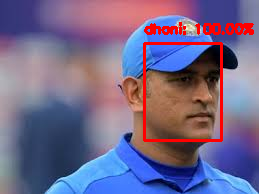

In [0]:
image = cv2.imread(imagePath)
(h,w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

detector.setInput(blob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    # fillter out weak detections
    if confidence > 0.2:
        # compute the coordinates of the bounding box for the face
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # face ROI
        face = image[startY:endY , startX:endX]
        (fH ,fW) = face.shape[:2]
        # ensure the facce width and height are sufficently large
        if fW < 20 or fH < 20:
            print("[Error] - Face size in Image not sufficent to generate Embeddings : ", imagePath)
            continue
        try:
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
        except:
            print("[Error] - Face size in Image not sufficent to generate Embeddings : ", imagePath)
            continue
        faceTensor = torch.tensor(faceBlob)
        faceEmbed = embedder(faceTensor)
        flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
        array = np.array(flattenEmbed).reshape(1,-1)       

        # performing  classification to recognize the face
        preds = recognizer.predict_proba(array)[0]
        j = np.argmax(preds)
        proba = preds[j]  
        name = label.classes_[j]
        #draw the bunding box of the face along with  probability
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
# save image predicte foler
cv2.imwrite("{}/{}.png".format(predictedImg, name), image)
im = Image.open("{}/{}.png".format(predictedImg, name))
im

# Generating Requirement file

In [0]:
!pip freeze > requirements.txt